## Exploring 1D scattering problems on a lattice

First let us load `matplotlib` and `numpy` by evoking `pylab` and also let us import interactive widgets from `ipywidgets`. This is a quick and easy way to set up a simple environment for numerical calculations. 

In [1]:
%pylab inline
from ipywidgets import *

Populating the interactive namespace from numpy and matplotlib


Now let us write a small class implementing 1D semi-infinite leads. The class below is just a simple collection of the analytic formilae for spectrum, groupvelocity and the surface Green's function. Most functions have some meaningfull standard parameters (*e.g.:* hopping $\gamma=-1$, on-site potential $\varepsilon_0=0$). The functions are written keeping in mind that for a generic scattering problem energy is the important variable and not the wavenumber.

In [2]:
class lead1D:
    'A class for simple 1D leads'
    def __init__(self,eps0=0,gamma=-1,**kwargs):
        'We assume real hopping \gamma and onsite \epsilon_0 parameters!'
        self.eps0=eps0
        self.gamma=gamma
        return
    
    def Ek(self,k):
        'Spectrum as a function of k'
        return self.eps0+2*self.gamma*cos(k)
    
    def kE(self,E,**kwargs):
        '''
        Spectrum as a function of E.
        If keyword a=True is given than 
        it gives back two k values, 
        one positive and one negative.
        '''
        a = kwargs.get('a',False)
        k=arccos((E-self.eps0)/(2*self.gamma))
        if a:
            return array([-k,k])
        else:
            return k
        
    def vE(self,E=0,**kwargs):
        '''
        Group velocity as a function of E.
        If keyword a=True is given than 
        it gives back two v values, 
        one positive and one negative.
        '''
        a = kwargs.get('a',False)
        k=self.kE(E)
        v= -2*self.gamma*sin(k)
        if a:
            return array([-v,v])
        else:
            return v
    
    
    def sgf(self,E=0):
        '''
        Surgace Green's function of a seminfinite 1D lead.
        '''
        return exp(1.0j *self.kE(E))/self.gamma
    
    def sgfk(self,k=pi/2):
        '''
        Surgace Green's function of a seminfinite 1D lead in terms of k.
        '''
        return exp(1.0j*k)/self.gamma
    
    def vk(self,k=pi/2):
        '''
        Group velocity in terms of k
        '''
        return -2*self.gamma*sin(k)
        

Let us investigate the following simple scattering setups:


![setups](geometries_1D.svg)

For each system we shall write a small function that generates the scattering matrix of the problem as a function of the energy $E$ and other relevant parameters. We start by the tunnel junction where we only have $\alpha$ the hopping matrix element coupling the two leads as parameter

In [3]:
def Smat_tunnel(E,alpha):
    
    #Definition of the leads
    L1=lead1D()
    L2=lead1D()
    E=E+0.0000001j # In order to make stuff meaningfull for
                # outside of the band we add a tiny 
                # imaginary part to the energy
            
    #Green's function of decoupled leads
    g0= array([[L1.sgf(E=E),0       ],
               [0       ,L2.sgf(E=E)]])
    
    #Potential coupling the leads
    V= array([[0  ,alpha],
              [alpha,0]])
    
    #Dyson's equation
    G=inv(inv(g0)-V)
    
    #is the channel open?
    #since both sides have the same 
    #structure they are open or closed 
    #at the same time
    isopen=int(imag(L1.kE(E))<0.001)
    
    #vector of the sqrt of the velocities
    vs=sqrt(array([[L1.vE(E=E)],[L2.vE(E=E)]]))

    #Scattering matrix from Fisher-Lee relations
    return matrix(1.0j*G*(vs*vs.T)-eye(2))*isopen
    
    

Now we write a small script tog generate a figure interactively depending on $\alpha$ so we can explore the parameterspace. We have also included an extra factor on top of the Fisher-Lee relations taking in if a channel is open or not.

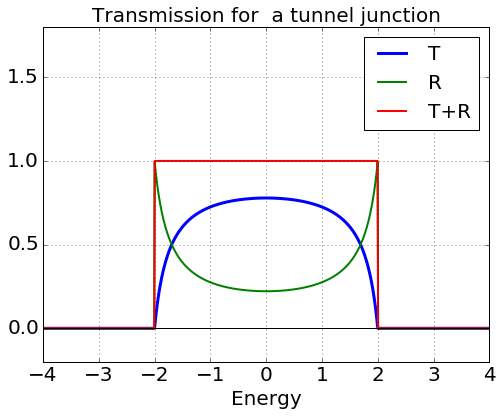

In [4]:
energy_range=linspace(-4,4,1000) # this will be the plotted energy range
figsize(8,6) # setting the figure size
fts=20       # the default font is a bit too small so we make it larger

#using the interact decorator we can have an interactive plot
@interact(alpha=FloatSlider(min=-2,max=2,step=0.1,value=-1,description=r'$\alpha$'))
def tunnel(alpha=-1):
    '''
    This function draws a picture of the transmission and reflection coefficitents
    of a 1D tunneljunction
    '''
    TR=[] # we shall collect the values to be plotted in these variables
    REF=[]
    for ene in energy_range:                # energy scan
        SS=Smat_tunnel(ene,alpha)           # obtain S-matrix
        TR.append(abs(SS[0,1])**2)          # extract transmission coeff.
        REF.append(abs(SS[0,0])**2)         # extract reflection coeff.
    TR=array(TR)
    REF=array(REF)
    # make a pretty plot
    plot(energy_range,TR,label='T',linewidth=3)
    plot(energy_range,REF,label='R',linewidth=2)
    plot(energy_range,REF+TR,label='T+R',linewidth=2)
    plot(energy_range,zeros_like(energy_range),'k-')
    ylim(-0.2,1.8);
    xticks(fontsize=fts)
    yticks(fontsize=fts)
    xlabel('Energy',fontsize=fts);
    legend(fontsize=fts);
    grid();
    title('Transmission for  a tunnel junction',fontsize=fts)

    


Similarly to the tunnel junction we start by a function that generates the scattering matrix. We have to be carefull since now the Green's function of the decoupled system is a $3\times3$ object. 

In [5]:
def Smat_BW(E,t1,t2,eps1):
    
    #Definition of the leads
    L1=lead1D()
    L2=lead1D()
    E=E+0.000000001j # In order to make stuff meaningfull for
                # outside of the band we add a tiny 
                # imaginary part to the energy
            
    #Green's function of decoupled system
    #Note that the Green's function of a 
    #decoupled single site is just the reciprocal 
    #of (E-eps1) !!
    g0= array([[L1.sgf(E=E),0       ,0],
               [0       ,L2.sgf(E=E),0],
               [0       ,0          ,1/(E-eps1)]])
    
    #Potential coupling the leads
    V= array([[0 ,0 ,t1],
              [0 ,0 ,t2],
              [t1,t2,0 ]])
    
    #Dyson's equation
    G=inv(inv(g0)-V)

    #is the channel open?
    isopen=int(imag(L1.kE(E))<0.001)

    #vector of the sqrt of the velocities
    vs=sqrt(array([[L1.vE(E=E)],[L2.vE(E=E)]]))
    

    #Scattering matrix from Fisher-Lee relations 
    #Note that we only need the matrix elements 
    #of the Green's functions on the "surface"
    #that is only the upper 2x2 part!
    return matrix(1.0j*G[:2,:2]*(vs*vs.T)-eye(2))*isopen

Now we can write again a script for a nice interactive plot

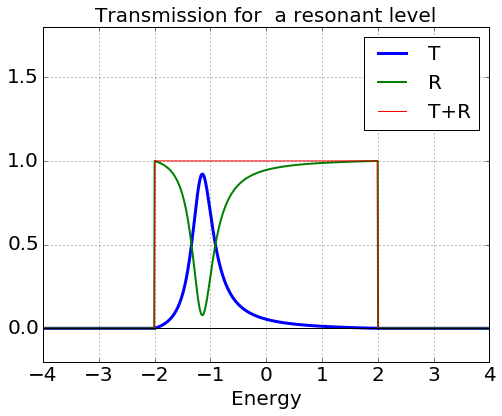

In [6]:
energy_range=linspace(-4,4,1000)
figsize(8,6)
fts=20
@interact(t1=FloatSlider(min=-2,max=2,step=0.1,value=-1,description=r'$\gamma_L$'),
          t2=FloatSlider(min=-2,max=2,step=0.1,value=-1,description=r'$\gamma_R$'),
          eps1=FloatSlider(min=-2,max=2,step=0.1,value=0,description=r'$\varepsilon_1$'))
def BW(t1=-1,t2=-1,eps1=0):
    TR=[]
    REF=[]
    for ene in energy_range:
        SS=Smat_BW(ene,t1,t2,eps1)
        TR.append(abs(SS[0,1])**2)
        REF.append(abs(SS[0,0])**2)
    TR=array(TR)
    REF=array(REF)
    plot(energy_range,TR,label='T',linewidth=3)
    plot(energy_range,REF,label='R',linewidth=2)
    plot(energy_range,REF+TR,label='T+R',linewidth=1)
    plot(energy_range,zeros_like(energy_range),'k-')
    ylim(-0.2,1.8);
    xticks(fontsize=fts)
    yticks(fontsize=fts)
    xlabel('Energy',fontsize=fts);
    legend(fontsize=fts);
    grid();
    title('Transmission for  a resonant level',fontsize=fts)

    


# Exercises

1. Using the above two examples write a a code that explores Fano resonance in a resonant level coupled sideways to a lead!
2. Using the above examples write a code that explores the Aharonov-Bohm effect!

## Some more examples

A simple potential step. The onsite potential in the right lead is shifted by $V_0$. Now in general the number of open chanels in the left and right lead are not the same. If the right channel is closed than we can only have reflection. 

In [7]:
def Smat_step(E,V0):
    
    #Definition of the leads
    L1=lead1D()
    L2=lead1D(eps0=V0)
    E=E+0.0001j # In order to make stuff meaningfull for
                # outside of the band we add a tiny 
                # imaginary part to the energy
            
    #Green's function of decoupled leads
    g0= array([[L1.sgf(E=E),0       ],
               [0       ,L2.sgf(E=E)]])
    
    #Potential coupling the leads
    V= array([[0  ,-1],
              [-1,0]])
    
    #Dyson's equation
    G=inv(inv(g0)-V)
    
    #is the channel open?
    isopen=array([[float(imag(L1.kE(E))<0.001)],[float(imag(L2.kE(E))<0.001)]])

    
    #vector of the sqrt of the velocities
    vs=sqrt(array([[L1.vE(E=E)],[L2.vE(E=E)]]))

    #Scattering matrix from Fisher-Lee relations
    return matrix((1.0j*G*(vs*vs.T)-eye(2))*isopen*isopen.T)
    
    

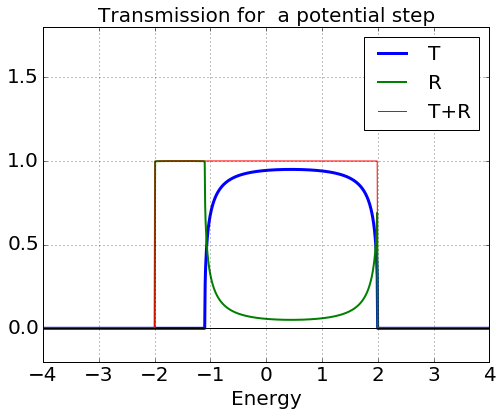

In [8]:
energy_range=linspace(-4,4,1000)
figsize(8,6)
fts=20

@interact(V0=FloatSlider(min=-2,max=2,step=0.1,value=0,description=r'$V_0$'))
def step(V0):
    TR=[]
    REF=[]
    for ene in energy_range:
        SS=Smat_step(ene,V0)
        TR.append(abs(SS[0,1])**2)
        REF.append(abs(SS[0,0])**2)
    TR=array(TR)
    REF=array(REF)
    plot(energy_range,TR,label='T',linewidth=3)
    plot(energy_range,REF,label='R',linewidth=2)
    plot(energy_range,REF+TR,label='T+R',linewidth=1)
    plot(energy_range,zeros_like(energy_range),'k-')
    plot()
    ylim(-0.2,1.8);
    xticks(fontsize=fts)
    yticks(fontsize=fts)
    xlabel('Energy',fontsize=fts);
    legend(fontsize=fts);
    grid();
    title('Transmission for  a potential step',fontsize=fts)

    


This is a simple model of a Fabry-Perot resonator realised by two tunnel barriers. This example also illustrates how we can have a larger scattering region.

In [9]:
def Smat_FP(E,t1,t2,N):
    
    # Definition of the leads
    L1=lead1D()
    L2=lead1D()
    E=E+0.000000001j # In order to make stuff meaningfull for
                     # outside of the band we add a tiny 
                     # imaginary part to the energy
            
    # Green's function of decoupled system
    # leads
    g0L= array([[L1.sgf(E=E),0       ],
                [0       ,L2.sgf(E=E)]])
    # the quantum dot
    g0S= inv(E*eye(N)-(-eye(N,N,-1)-eye(N,N,1)))
    
    Z=zeros((len(g0L[0,:]),len(g0S[:,0])))
    # decoupled full Green's function is built up by stacking the 
    # 
    g0=vstack((hstack((g0L,Z  )),
               hstack((Z.T,g0S))))
    
    v=zeros_like(Z)
    v[0,0]=t1
    v[-1,-1]=t2
    #Potential coupling the leads
    V=vstack((hstack((zeros_like(g0L),v  )),
               hstack((v.T           ,zeros_like(g0S))) ))

    
    #Dyson's equation
    G=inv(inv(g0)-V)
    
    #is the channel open?
    isopen=array([[float(imag(L1.kE(E))<0.001)],[float(imag(L2.kE(E))<0.001)]])

    
    #vector of the sqrt of the velocities
    vs=sqrt(array([[L1.vE(E=E)],[L2.vE(E=E)]]))

    #Scattering matrix from Fisher-Lee relations
    return matrix((1.0j*G[0:2,0:2]*(vs*vs.T)-eye(2))*isopen*isopen.T)
    
    

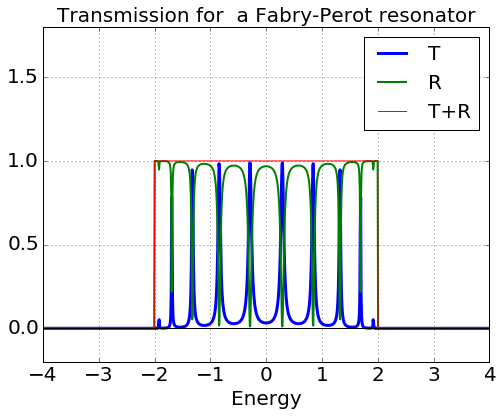

In [10]:
energy_range=linspace(-4,4,1000)
figsize(8,6)
fts=20
@interact(t1=FloatSlider(min=-2,max=2,step=0.1,value=-1,description=r'$\gamma_L$'),
          t2=FloatSlider(min=-2,max=2,step=0.1,value=-1,description=r'$\gamma_R$'),
          N=IntSlider(min=1,max=10,value=1,description=r'$N$'))
def FP(t1=-1,t2=-1,N=1):
    TR=[]
    REF=[]
    for ene in energy_range:
        SS=Smat_FP(ene,t1,t2,N)
        TR.append(abs(SS[0,1])**2)
        REF.append(abs(SS[0,0])**2)
    TR=array(TR)
    REF=array(REF)
    plot(energy_range,TR,label='T',linewidth=3)
    plot(energy_range,REF,label='R',linewidth=2)
    plot(energy_range,REF+TR,label='T+R',linewidth=1)
    plot(energy_range,zeros_like(energy_range),'k-')
    ylim(-0.2,1.8);
    xticks(fontsize=fts)
    yticks(fontsize=fts)
    xlabel('Energy',fontsize=fts);
    legend(fontsize=fts);
    grid();
    title('Transmission for  a Fabry-Perot resonator',fontsize=fts)

    
